## Modélisation

In [1]:
# tables
import pandas as pd
import numpy as np
# graphics
import seaborn as sns
import matplotlib.pyplot as plt
# text processing
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
# expressions
import re
# machine learning
from sklearn.model_selection import train_test_split
# Deal with html text
from bs4 import BeautifulSoup
# Multiprocessing
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
# Import the wordcloud library
from wordcloud import WordCloud

### Application d'une méthode non supervisée de modélisation des tags

### 2.1 Implémentation d'une LDA sur les titres des questions:

Pour notre approche non supervisée, nous utiliserons en premier lieu uniquement les tags. Ceux-ci contiennent en général les informations spécifiques au sujet de la question et sont, a priori, suffisants pour avoir une idée du contenu de celle-ci.

- On utilise une LDA (Latent Dirichlet Allocation) pour obtenir une liste des sujets ou topics principaux des questions dont nous disposons

Chargement du "bag of words" obtenu précedemment. 

In [2]:
df_bag = pd.read_hdf("output/classic_bag" + "4" + ".h5", index='False', key='stage', mode='r')
print("Le bag entier a un nombre total de {} mots".format(df_bag.shape[1]))

# Séparation des 'bags'
df_bag_train = df_bag.loc[df_bag["Train"] == 1]
df_bag_test = df_bag.loc[df_bag["Train"] == 0]

Le bag entier a un nombre total de 44413 mots


In [3]:
df_bag

,00,000,0000,00000,000000,00000000,0000000000000000000000000,000000000000000e,000000000000054390,000000000000484240fa063de5d0b744adbed63a81faea390000c8428640a43d5005bd44,...,ﾀﾀ,ﾁﾒ,ﾔﾻ,ﾙﾺ,ﾝﾉ,ﾨﾈ,ﾱﾱ,Id,Tags,Train
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,174322,[perforce],1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,435582,"[c#, asp.net, sql-server, session-state]",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,179448,"[linux, kde]",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,468742,"[.net, asp.net, asp.net-mvc]",1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,93162,[wcf],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,111945,"[python, http, put]",0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,461569,"[.net, remoting]",0
2998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,494432,"[latex, tex]",0
2999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,339747,"[asp.net, web-services, multithreading, asynch...",0


In [4]:
df_bag["Tags"]

0                                              [perforce]
1                [c#, asp.net, sql-server, session-state]
2                                            [linux, kde]
3                            [.net, asp.net, asp.net-mvc]
4                                                   [wcf]
                              ...                        
2996                                  [python, http, put]
2997                                     [.net, remoting]
2998                                         [latex, tex]
2999    [asp.net, web-services, multithreading, asynch...
3000                               [asp.net-mvc, routing]
Name: Tags, Length: 15002, dtype: object

In [5]:
df_bag["Train"]

0       1
1       1
2       1
3       1
4       1
       ..
2996    0
2997    0
2998    0
2999    0
3000    0
Name: Train, Length: 15002, dtype: int64

In [6]:
df_bag_train["Train"]

0        1
1        1
2        1
3        1
4        1
        ..
11996    1
11997    1
11998    1
11999    1
12000    1
Name: Train, Length: 12001, dtype: int64

In [7]:
df_bag_train["Tags"]

0                                      [perforce]
1        [c#, asp.net, sql-server, session-state]
2                                    [linux, kde]
3                    [.net, asp.net, asp.net-mvc]
4                                           [wcf]
                           ...                   
11996           [javascript, syntax-highlighting]
11997            [url, standards, file-extension]
11998                            [seo, googlebot]
11999                [.net, ado.net, rhino-mocks]
12000              [version-control, open-source]
Name: Tags, Length: 12001, dtype: object

Visualisation de tous nos tags

In [8]:
texts_tags = []
for i in range(len(df_bag_train)):
    # Récupération de la première ligne du 'bag of word'
    inputs = df_bag_train["Tags"][i]#.values#.loc[row,cols].values
    texts_tags.append(inputs)
print(texts_tags)

[['perforce'], ['c#', 'asp.net', 'sql-server', 'session-state'], ['linux', 'kde'], ['.net', 'asp.net', 'asp.net-mvc'], ['wcf'], ['ruby', 'perl', 'format'], ['iphone', 'iphone-web-app'], ['c++', 'winapi', 'png'], ['visual-c++', 'mfc', 'menu'], ['c#', 'logging', 'enterprise-library', 'application-blocks'], ['coding-style', 'maintenance'], ['beta'], ['php'], ['asp.net', 'visual-studio', 'visual-studio-2008'], ['mysql', 'server-hardware'], ['java', 'date', 'timestamp', 'gettime'], ['sql', 'oracle', 'optimization'], ['html', 'firefox', 'autocomplete', 'passwords'], ['vba', 'soap'], ['webserver', 'file-upload'], ['architecture', 'msmq', 'message-queue'], ['python', 'django', 'spell-checking'], ['unit-testing'], ['java'], ['c#-2.0'], ['mysql', 'grails'], ['c#', 'loops', 'lambda', 'capture'], ['regex', 'nested', 'finite-automata'], ['c', 'sockets', 'unix'], ['hardware', 'development-environment', 'cpu'], ['asp.net', 'jquery', 'ajax', 'asp.net-ajax', 'forms-authentication'], ['javascript', 'reg

Nous allons utilisé la fonction map() pour extraire tous nos tags de notre "bags of words"

In [9]:
all_tags = df_bag_train["Tags"].map(lambda field:field)

In [10]:
all_tags.values

array([list(['perforce']),
       list(['c#', 'asp.net', 'sql-server', 'session-state']),
       list(['linux', 'kde']), ..., list(['seo', 'googlebot']),
       list(['.net', 'ado.net', 'rhino-mocks']),
       list(['version-control', 'open-source'])], dtype=object)

In [11]:
np_text = df_bag_train["Tags"].values.copy()
full_text_tags_splitted = []
for i in range(len(np_text)):
    full_text_tags_splitted.extend(np_text[i])
full_text_tags_splitted[0:20]
del np_text

In [12]:
full_text_tags_splitted

['perforce',
 'c#',
 'asp.net',
 'sql-server',
 'session-state',
 'linux',
 'kde',
 '.net',
 'asp.net',
 'asp.net-mvc',
 'wcf',
 'ruby',
 'perl',
 'format',
 'iphone',
 'iphone-web-app',
 'c++',
 'winapi',
 'png',
 'visual-c++',
 'mfc',
 'menu',
 'c#',
 'logging',
 'enterprise-library',
 'application-blocks',
 'coding-style',
 'maintenance',
 'beta',
 'php',
 'asp.net',
 'visual-studio',
 'visual-studio-2008',
 'mysql',
 'server-hardware',
 'java',
 'date',
 'timestamp',
 'gettime',
 'sql',
 'oracle',
 'optimization',
 'html',
 'firefox',
 'autocomplete',
 'passwords',
 'vba',
 'soap',
 'webserver',
 'file-upload',
 'architecture',
 'msmq',
 'message-queue',
 'python',
 'django',
 'spell-checking',
 'unit-testing',
 'java',
 'c#-2.0',
 'mysql',
 'grails',
 'c#',
 'loops',
 'lambda',
 'capture',
 'regex',
 'nested',
 'finite-automata',
 'c',
 'sockets',
 'unix',
 'hardware',
 'development-environment',
 'cpu',
 'asp.net',
 'jquery',
 'ajax',
 'asp.net-ajax',
 'forms-authentication',
 'j

On affiche quelques 'tags' sous forme de Word Clouds afin d'évaluer les résultats:

In [13]:
vectorizer = CountVectorizer(dtype=np.uint8)
tags_CV=vectorizer.fit_transform(full_text_tags_splitted)
title_feature_names=vectorizer.get_feature_names()

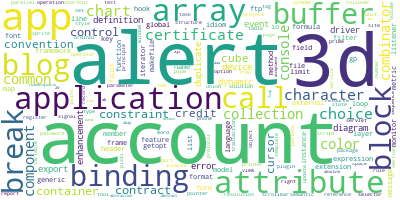

In [14]:
# Join the different processed titles together.
long_string = ','.join(list(title_feature_names))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

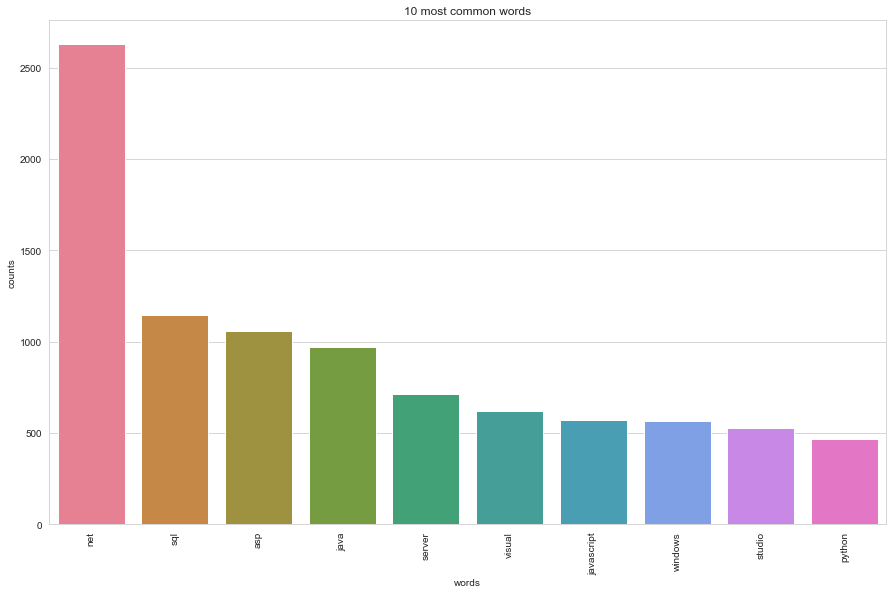

In [15]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(full_text_tags_splitted)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [16]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
asp net javascript mvc wpf language control delphi version string

Topic #1:
sql server visual studio jquery css 2008 xml winforms 2005

Topic #2:
java windows php ruby mysql testing services file rails linq

Topic #3:
python performance apache algorithm iis web actionscript wcf flex http

Topic #4:
net database html vb interface design eclipse ajax svn user


In [17]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

CPU times: user 103 ms, sys: 25.3 ms, total: 128 ms
Wall time: 154 ms


In [18]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [19]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.195336  0.327201       1        1  23.111603
0     -0.253999  0.013952       2        1  20.372251
2      0.181912 -0.220104       3        1  20.340994
4     -0.238884  0.017865       4        1  19.462280
3      0.115635 -0.138914       5        1  16.712872, topic_info=          Term         Freq        Total Category  logprob  loglift
2207       net  2421.000000  2421.000000  Default  30.0000  30.0000
199        asp   983.000000   983.000000  Default  29.0000  29.0000
3224       sql  1001.000000  1001.000000  Default  28.0000  28.0000
1720      java   857.000000   857.000000  Default  27.0000  27.0000
3057    server   621.000000   621.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1323  function    43.775095    44.495729   Topic5  -5.0702   1.7727
321        bit    41.794530    42.5

In [20]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

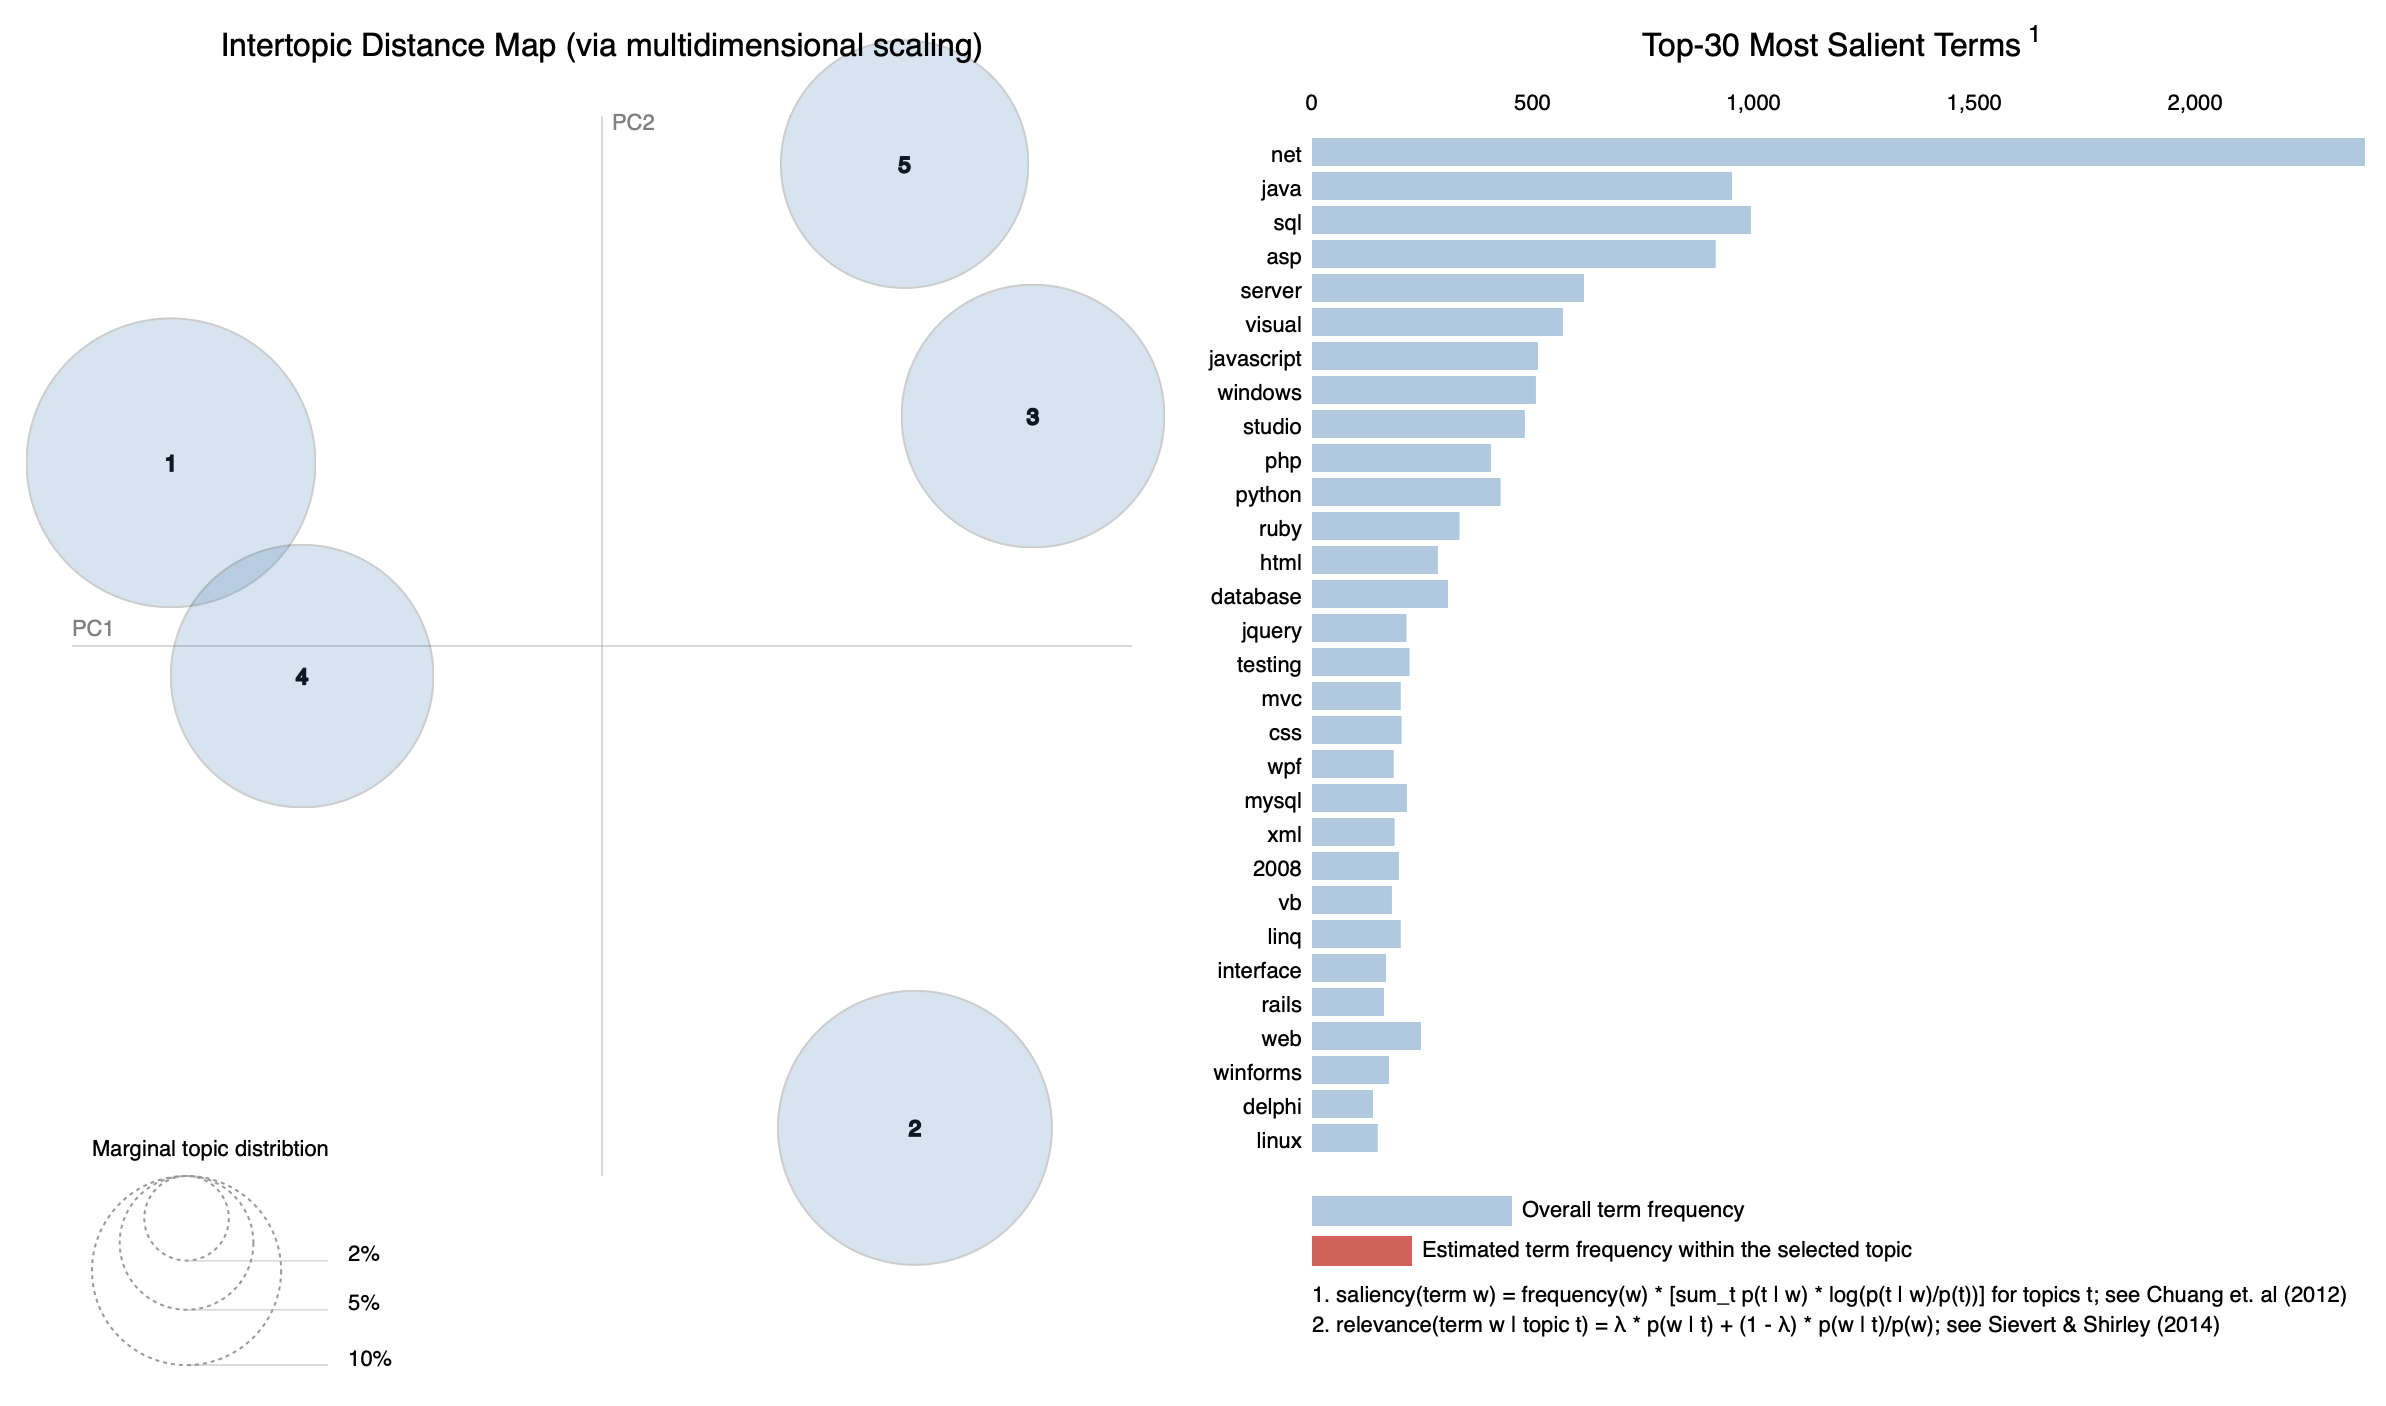

In [35]:
from IPython.display import Image
Image("./picture.png")

## Application d'une méthode supervisée de classification multi-label pour prédire les tags

Nous allons maintenant entraîner plusieurs modèles de classification supervisée sur les données dans le but de prédire les tags associés à une question. Notre approche consistera d'abord à tester plusieurs modèles et de comparer leurs perfomances respectives. L'évaluation des performances sera réalisée par le biais de plusieurs métriques prenant en compte la nature des labels('tags' multiples) afin de sélectionner le modèle le plus probant vis-à-vis de la problématique. Le but est de sélectionner 3 modèles qui seront entraînés respectivement sur les 'tags', 'Tilte' et 'Body'. Le modèle final consistera en un voting des trois modèles. Afin d'avoir plus de données d'entraînement, cette partie utilisera un data contenant 100 000 questions.

In [21]:
df_bag_train

,00,000,0000,00000,000000,00000000,0000000000000000000000000,000000000000000e,000000000000054390,000000000000484240fa063de5d0b744adbed63a81faea390000c8428640a43d5005bd44,...,ﾀﾀ,ﾁﾒ,ﾔﾻ,ﾙﾺ,ﾝﾉ,ﾨﾈ,ﾱﾱ,Id,Tags,Train
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,174322,[perforce],1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,435582,"[c#, asp.net, sql-server, session-state]",1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,179448,"[linux, kde]",1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,468742,"[.net, asp.net, asp.net-mvc]",1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,93162,[wcf],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,113440,"[javascript, syntax-highlighting]",1
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,322944,"[url, standards, file-extension]",1
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,262135,"[seo, googlebot]",1
11999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,155797,"[.net, ado.net, rhino-mocks]",1


In [22]:
df_bag_train.loc[0:5, "Tags"]

0                                  [perforce]
1    [c#, asp.net, sql-server, session-state]
2                                [linux, kde]
3                [.net, asp.net, asp.net-mvc]
4                                       [wcf]
5                        [ruby, perl, format]
Name: Tags, dtype: object

In [23]:
df_bag_train.shape

(12001, 44413)

(4022, 2)

------------------Top 20 tags:--------------------------


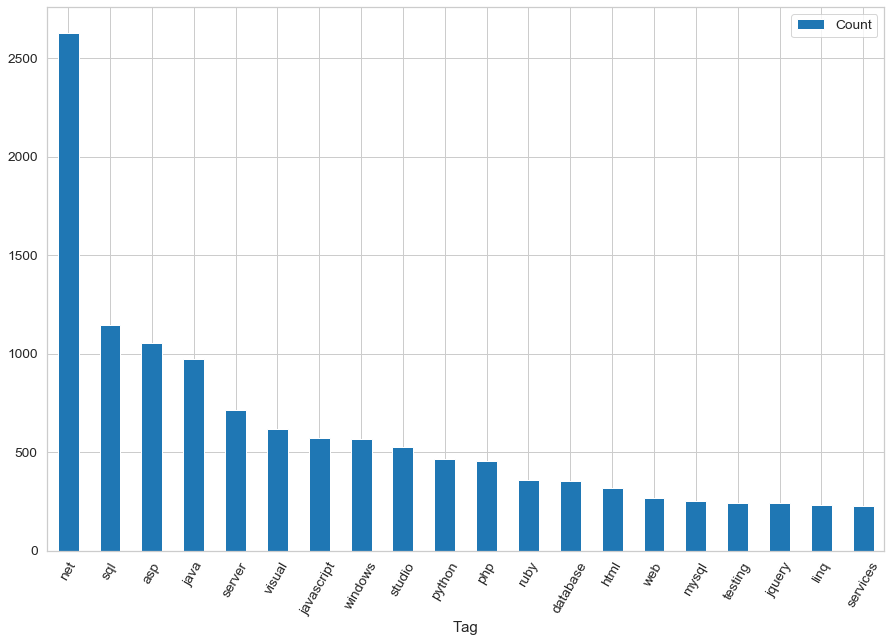

In [24]:
tag_vectorizer = CountVectorizer(dtype=np.uint8)
tag_CV=tag_vectorizer.fit_transform(full_text_tags_splitted)
tag_names=tag_vectorizer.get_feature_names()
# Somme de chaque mots du vocabulaire 
tag_CV=tag_CV.toarray()
dist = np.sum(tag_CV, axis=0)
sorted_counts=dist.argsort()
tags={}
for i in sorted_counts:
    tags[tag_names[i]]=dist[i]
tags_df=pd.DataFrame(columns=['Tag', 'Count'])
tags_df['Tag']=list(tags.keys())
tags_df['Count']=list(tags.values())
tags_df.sort_values(by=['Count'],ascending=False,inplace=True)
print(tags_df.shape)

tags_df[0:20].plot.bar(x='Tag',y='Count',rot=60,figsize=(15,10))
print("\n------------------Top 20 tags:--------------------------")

In [25]:
# Créer une liste des index de balises par ordre décroissant de fréquence pour les chaînes de classifieur
tag_order_dict={}
for index,tag in enumerate(list(df_bag_train.columns)):
    tag_order_dict[tag]=index
tags_ordered_indexes=[]
for tag in df_bag_train['Tags']:
    try:
        tags_ordered_indexes.append(tag_order_dict[tag])
    except:
        pass

In [26]:
df_train = df_bag_train.drop(columns=["Id", "Tags", 'Train']) 
df_test = df_bag_test.drop(columns=["Id", "Tags", 'Train'])

In [27]:
Y_train = df_bag_train["Tags"]

In [28]:
df =  df_train.apply(lambda x: np.str_(x))

In [29]:
df

00        0        0\n1        0\n2        0\n3        0...
000       0        0\n1        0\n2        0\n3        0...
0000      0        0\n1        0\n2        0\n3        0...
00000     0        0\n1        0\n2        0\n3        0...
000000    0        0\n1        0\n2        0\n3        0...
                                ...                        
ﾔﾻ        0        0\n1        0\n2        0\n3        0...
ﾙﾺ        0        0\n1        0\n2        0\n3        0...
ﾝﾉ        0        0\n1        0\n2        0\n3        0...
ﾨﾈ        0        0\n1        0\n2        0\n3        0...
ﾱﾱ        0        0\n1        0\n2        0\n3        0...
Length: 44410, dtype: object

In [30]:
y= Y_train.apply(lambda x: np.str_(x))

In [31]:
y

0                                            ['perforce']
1        ['c#', 'asp.net', 'sql-server', 'session-state']
2                                        ['linux', 'kde']
3                      ['.net', 'asp.net', 'asp.net-mvc']
4                                                 ['wcf']
                               ...                       
11996               ['javascript', 'syntax-highlighting']
11997              ['url', 'standards', 'file-extension']
11998                                ['seo', 'googlebot']
11999                  ['.net', 'ado.net', 'rhino-mocks']
12000                  ['version-control', 'open-source']
Name: Tags, Length: 12001, dtype: object

In [32]:
y.shape

(12001,)

In [33]:
df.shape

(44410,)

In [34]:
df = df[:12001]
df.shape

(12001,)

In [35]:
X_train, X_test, y_train, y_test= train_test_split(df, y, test_size=0.2)

In [36]:
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [59]:
title_vectorizer= CountVectorizer(dtype=np.uint8)

x_train=title_vectorizer.fit_transform(X_train)#(X_train.apply(lambda x: np.str_(x)))
x_test=title_vectorizer.transform(X_test)#(X_test.apply(lambda x: np.str_(x)))

# initialize classifier chains multi-label classifier
cmb_title = ClassifierChain(ComplementNB(), order=tags_ordered_indexes)
mnb_title = ClassifierChain(MultinomialNB(), order=tags_ordered_indexes)
 
# Training model on train data
cmb_title.fit(x_train, y_train)
mnb_title.fit(x_train, y_train)

predictions_cmb_title= cmb_title.predict(x_test)
predictions_mnb_title= mnb_title.predict(x_test)  

precision_scores_titles=pd.DataFrame(columns=['Model'])
precision_scores_titles['Model']=['MultinomialNB Titles','ComplementNB Titles']

for col, metric in zip(['Accuracy','Hamming Loss','Wrong Labels','Missed Labels'], [accuracy_score, hamming_loss, wrong_label_counter, missed_label_counter]):
  precision_scores_titles[col]=[metric(y_test, predictions_mnb_title), metric(y_test, predictions_cmb_title) ]
  
precision_scores_titles.style

IndexError: tuple index out of range

## Random Forest

In [37]:
title_vectorizer= CountVectorizer(dtype=np.uint8)

x_train=title_vectorizer.fit_transform(X_train)#(X_train.apply(lambda x: np.str_(x)))
x_test=title_vectorizer.transform(X_test)#(X_test.apply(lambda x: np.str_(x)))

In [38]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['00904', '00907', '00932', '00933', '00942', '01461', '03', '1045', '1067', '11', '1241', '1242', '12519', '16', '17', '2000', '2003', '2005', '2006', '2007', '2008', '2009', '2010', '2012', '2d', '2to3', '301', '32', '3d', '3ds', '400', '404', '405', '503', '64', '754', '7zip', '8859', '97', '98', 'aaa', 'aac', 'aasm', 'ab', 'abap', 'absolute', 'abstract', 'abstraction', 'accelerator', 'acceptance', 'access', 'accessibility', 'accessor', 'accordion', 'accordionpane', 'account', 'accounts', 'accuracy', 'accurev', 'acl', 'acpi', 'acrobat', 'action', 'actionmailer', 'actionresult', 'actionscript', 'activator', 'active', 'activemq', 'activerecord', 'activereports', 'activestate', 'activex', 'activity', 'ada', 'adaption', 'adaptive', 'add', 'addeventlistener', 'addins', 'addition', 'addon', 'addremoveprograms', 'address', 'addressing', 'adf', 'adhoc', 'adjacency', 'admin', 'administration', 'administrator', 'ado', 'adobe', 'adodb', 'adomd', 'adp', 'adsense', 'adsi', 'adventureworks', 'adw

In [39]:
print("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(x_train, y_train)

Training the random forest...


In [44]:
result = forest.predict(x_test)

In [60]:
result

array(["['asp.net']", "['asp.net']", "['asp.net']", ..., "['asp.net']",
       "['asp.net']", "['asp.net']"], dtype=object)

In [57]:
forest.feature_importances_

array([1.11621897e-04, 1.15707597e-04, 8.86566636e-05, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [45]:
precision_scores_titles=pd.DataFrame(columns=['Random Forest'])

In [55]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), result), 
             reverse=True))

Features sorted by their score:
[(0.0001, "['linux', 'crash', 'coredump']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']"), (0.0001, "['asp.net']")